In [348]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [349]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

In [350]:
def get_home_game_points(row):
    if row['goal1'] > row['goal2']:
        return 3
    elif row['goal1'] < row['goal2']:
        return 0
    else:
        return 1

def get_guest_game_pints(row):
    if row['goal1'] > row['goal2']:
        return 0
    elif row['goal1'] < row['goal2']:
        return 3
    else:
        return 1

In [351]:
def get_group_table(df, group_name):   
    group_games = games_df[games_df['group'] == group_name]
    group_teams = pd.concat([group_games['team1'], group_games['team2']]).unique()
    group_table = []
    for team in group_teams:
        # Считаем таблицу "домашних" игр
        team_home_games = group_games[group_games['team1']==team]
        team_home_games['points'] = team_home_games.apply(get_home_game_points,axis=1)
        # Считаем таблицу "гостевых" игр
        team_guest_games = group_games[group_games['team2']==team]
        team_guest_games['points'] = team_guest_games.apply(get_guest_game_pints,axis=1)
        # Объединяем общую таблицу
        team_games= pd.concat([team_home_games, team_guest_games],axis=0)
        team_games['points'] = team_games['points'].astype('int')
        # Суммарные характеристики
        team_points = team_games['points'].sum()
        team_goals_scored = team_home_games['goal1'].sum() + team_guest_games['goal2'].sum()
        team_goals_missed = team_home_games['goal2'].sum() + team_guest_games['goal1'].sum()
        group_table.append([team, team_points, team_goals_scored, team_goals_missed])
    
    group_table = pd.DataFrame(group_table, columns=['team', 'points', 'goals_scored', 'goals_missed'])
    group_table['goals_diff'] = group_table['goals_scored'] - group_table['goals_missed']
    group_table = group_table.sort_values(by='points',ascending=False)
    return group_table

Загружаем таблицы

In [352]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')
lineups_df = pd.read_csv('lineups.csv')
games_df = pd.read_csv('games.csv')

Правим таблицы

In [353]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
#lineups_df.columns=['game_id','country_id','name','in','out']
lineups_df['total'] = lineups_df['out'] - lineups_df['in']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)

## Предварительная статистика

In [355]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

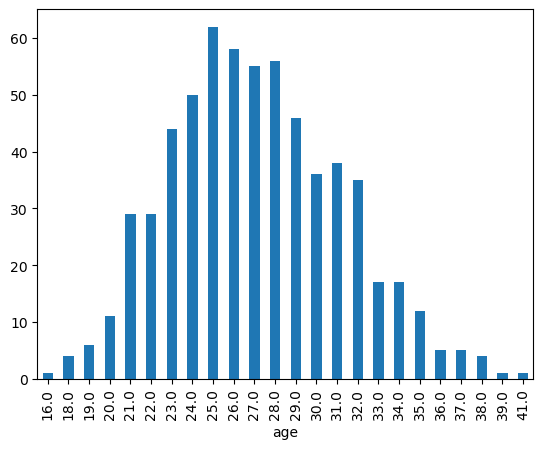

In [356]:
players.groupby('age')['num'].count().plot(kind='bar');

In [357]:
players['age'].describe()

count    622.000000
mean      27.106109
std        4.127399
min       16.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [358]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
574,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
589,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
544,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [359]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,16.0
405,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
464,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
541,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
561,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,18.0


Самые возрастные команды

In [360]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.576923
Шотландия,28.346154
Польша,27.807692
Дания,27.769231
Швейцария,27.730769


Самые молодые команды

In [361]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.807692
Англия,26.076923
Нидерланды,26.230769
Украина,26.384615


## Статистика турнира

### Турнирные таблицы

In [377]:
from string import ascii_uppercase as alc
for i in range(6):
    print('Группа ' + alc[i])
    display(get_group_table(games_df, alc[i]))

Группа A


,team,points,goals_scored,goals_missed,goals_diff
0,Германия,3,5,1,4
3,Швейцария,3,3,1,2
1,Венгрия,0,1,3,-2
2,Шотландия,0,1,5,-4


Группа B


,team,points,goals_scored,goals_missed,goals_diff
0,Испания,3,3,0,3
1,Италия,3,2,1,1
2,Хорватия,0,0,3,-3
3,Албания,0,1,2,-1


Группа C


,team,points,goals_scored,goals_missed,goals_diff
3,Англия,3,1,0,1
0,Словения,1,1,1,0
2,Дания,1,1,1,0
1,Сербия,0,0,1,-1


Группа D


,team,points,goals_scored,goals_missed,goals_diff
1,Нидерланды,3,2,1,1
0,Польша,0,1,2,-1


Группа E


,team,points,goals_scored,goals_missed,goals_diff
0,Румыния,3,3,0,3
3,Словакия,3,1,0,1
1,Бельгия,0,0,1,-1
2,Украина,0,0,3,-3


Группа F


,team,points,goals_scored,goals_missed,goals_diff


### Состав команды

In [363]:
lteam='Испания'
# Берем id страны
lteam_id = countries[countries['country']==lteam]['country_id']
lteam_id = lteam_id.reset_index(drop=True)[0] 

lplayers = players[players['country'] == lteam] # Общий состав страны
lplayers_array = players['name']
llineup = lineups_df[lineups_df['country_id']==lteam_id] # Выходы
lteam_players = lplayers.merge(llineup, how='left')
# Голы
lgoals = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'].isin(['гол','пенальти']))]
 .pivot_table(index='name', values='event', aggfunc='count'))
lgoals.columns = ['goals']
lteam_players = lteam_players.merge(lgoals, on='name', how='left')
# Ассисты
lassist = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'пас')]
 .pivot_table(index='name', values='event', aggfunc='count'))
lassist.columns = ['assist']
lteam_players = lteam_players.merge(lassist, on='name', how='left')
# Желтые карточки
lyellows = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'желтая карточка')]
 .pivot_table(index='name', values='event', aggfunc='count'))
lyellows.columns = ['yellows']
lteam_players = lteam_players.merge(lyellows, on='name', how='left')
# Красные карточки
try:
    lreds = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'красная карточка')]
     .pivot_table(index='name', values='event', aggfunc='count'))
    lreds.columns = ['reds']
    lreds
    lteam_players = lteam_players.merge(lreds, on='name', how='left')
except:
    lteam_players['reds'] = 0
lteam_players = lteam_players.drop(['country_id', 'country', 'game_id', 'in', 'out'], axis=1)
lteam_players = lteam_players.fillna(0)
lteam_players.sort_values(by='num')

,num,name,team,birthdate,pos,age,total,goals,assist,yellows,reds
0,1,Давид Райя,Арсенал,1995-09-15,врт,28.0,0.0,0.0,0.0,0.0,0
3,2,Дани Карвахаль,Реал Мадрид,1992-01-11,защ,32.0,90.0,1.0,0.0,0.0,0
4,3,Робен Ле Норман,Реал Сосьедад,1996-11-11,защ,27.0,90.0,0.0,0.0,0.0,0
5,4,Начо Фернандес,Реал Мадрид,1990-01-18,защ,34.0,90.0,0.0,0.0,0.0,0
6,5,Дани Вивиан,Атлетик Бильбао,1999-07-05,защ,24.0,0.0,0.0,0.0,0.0,0
11,6,Микель Мерино,Реал Сосьедад,1996-06-22,поз,28.0,22.0,0.0,0.0,0.0,0
18,7,Альваро Мората,Атлетико Мадрид,1992-10-23,нап,31.0,67.0,1.0,0.0,0.0,0
12,8,Фабиан Руис,Пари Сен-Жермен,1996-04-03,поз,28.0,90.0,1.0,1.0,0.0,0
19,9,Хоселу,Реал Мадрид,1990-05-27,нап,34.0,0.0,0.0,0.0,0.0,0
20,10,Дани Ольмо,РБ Лейпциг,1998-05-07,нап,26.0,31.0,0.0,0.0,0.0,0


### Средняя результативность матча

In [364]:
games_df['total_goals'] = games_df['goal1'] + games_df['goal2']
games_df['total_goals'].describe()

count    9.000000
mean     2.888889
std      1.536591
min      1.000000
25%      2.000000
50%      3.000000
75%      3.000000
max      6.000000
Name: total_goals, dtype: float64

### Бомбардиры

In [365]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Адам Букса,1
Коди Гакпо,1
Эмре Джан,1
Флориан Вирц,1
Фабиан Руис,1
Рэзван Марин,1
Николо Барелла,1
Николае Станчу,1
Никлас Фюллькруг,1


### Ассистены

In [366]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Деннис Ман,2
Натан Аке,2
Букайо Сака,1
Доминик Собослаи,1
Йозуа Киммих,1
Йонас Винд,1
Кай Хаверц,1
Ламин Ямаль,1
Лоренцо Пеллегрини,1


### Карточки

In [367]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Арбер Ходжа,1
Армандо Броя,1
Энтони Ралстон,1
Сильван Видмер,1
Рэзван Марин,1
Родри,1
Роберт Андрих,1
Риккардо Калафьори,1
Ремо Фройлер,1


In [368]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Райан Портеус,1


### Время игры

In [369]:
lineups_df.pivot_table(index='name', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(20)

,total
name,
Адам Букса,90.0
Ловро Майер,90.0
Йосип Станишич,90.0
Йосип Шутало,90.0
Йошко Гвардиол,90.0
Фабиан Шер,90.0
Кайл Уокер,90.0
Фабиан Руис,90.0
Каспер Шмейхель,90.0


## Старые игры

**Введите названия команд**

In [378]:
team1='Австрия'
team2='Франция'

**Игры между собой**

In [379]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))]

,game_id,date,team1,team2,goal1,goal2,description


**Игры домашней команды**

In [380]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
team1_df = pd.concat([team1h_df, team1g_df],axis=0)
display(team1_df.sort_values(by='date',ascending=False))
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
281,281,2023-11-16,Эстония,Австрия,0,2,квалификация ЧЕ-2024 группа F,победа
278,278,2023-10-16,Азербайджан,Австрия,0,1,квалификация ЧЕ-2024 группа F,победа
277,277,2023-10-13,Австрия,Бельгия,2,3,квалификация ЧЕ-2024 группа F,поражение
274,274,2023-09-12,Швеция,Австрия,1,3,квалификация ЧЕ-2024 группа F,победа
270,270,2023-06-20,Австрия,Швеция,2,0,квалификация ЧЕ-2024 группа F,победа
269,269,2023-06-17,Бельгия,Австрия,1,1,квалификация ЧЕ-2024 группа F,ничья
267,267,2023-03-27,Австрия,Эстония,2,1,квалификация ЧЕ-2024 группа F,победа
265,265,2023-03-24,Австрия,Азербайджан,4,1,квалификация ЧЕ-2024 группа F,победа
37,37,2021-06-26,Италия,Австрия,2,1,(ДВ) ЧЕ-2020 1/8 финала\t,поражение
26,26,2021-06-21,Украина,Австрия,0,1,ЧЕ-2020 Группа C тур 3,победа


,home,guest,total
result,,,
ничья,1,2,3
победа,4,4,8
поражение,4,3,7


**Игры гостевой команды**

In [381]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
#display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
#display(team2g_df)
team2_df = pd.concat([team2h_df, team2g_df],axis=0)
display(team2_df.sort_values(by='date',ascending=False))
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
203,203,2023-11-21,Греция,Франция,2,2,квалификация ЧЕ-2024 группа B,ничья
201,201,2023-11-18,Франция,Гибралтар,14,0,квалификация ЧЕ-2024 группа B,победа
197,197,2023-10-13,Нидерланды,Франция,1,2,квалификация ЧЕ-2024 группа B,победа
192,192,2023-09-07,Франция,Ирландия,2,0,квалификация ЧЕ-2024 группа B,победа
191,191,2023-06-19,Франция,Греция,1,0,квалификация ЧЕ-2024 группа B,победа
188,188,2023-06-16,Гибралтар,Франция,0,3,квалификация ЧЕ-2024 группа B,победа
187,187,2023-03-27,Ирландия,Франция,0,1,квалификация ЧЕ-2024 группа B,победа
184,184,2023-03-24,Франция,Нидерланды,4,0,квалификация ЧЕ-2024 группа B,победа
41,41,2021-06-28,Франция,Швейцария,3,3,пен 4 : 5 ЧЕ-2020 1/8 финала\t,ничья
34,34,2021-06-23,Португалия,Франция,2,2,ЧЕ-2020 Группа F тур 3,ничья


,home,guest,total
result,,,
ничья,2,5,7
победа,9,5,14
поражение,1,4,5


### Разное

In [374]:
players[players['team'].str.contains('Спартак Трнава')]

,num,name,team,birthdate,pos,country_id,country,age


In [375]:
players[players['name'].str.contains('Феликс')]

,num,name,team,birthdate,pos,country_id,country,age
591,11,Жуан Феликс,Барселона,1999-11-10,нап,23,Португалия,24.0
